# 2つのANNによる非線形歪補償
ANNによる予測後さらにもう1つのANNで予測する

In [1]:
#import
import sys
import os
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

sys.path.append('../')
from pyopt.util import save_pickle, load_pickle

# 1. Preproccessing

## 1.1 データの整形

In [16]:
def data_shaping1(input_signal, signal, max_tap, tap):
    """
    input_signal: 伝送前の信号
    signal: 伝送後の信号
    max_tap: 最大の同時入力シンボル数
    tap: 同時入力シンボル数
    
    signal = [x_0, x_1, ... , x_(n-1)]
      |
      |
      v
    x = [[x_0, x_1, ... , x_tap-1],
            [x_1, x_2, ..., x_tap],
                   .
                   .
                   .
            [x_(n-tap), x_(n-tap+1), ..., x(n-1)]]
      |
      |
      v
    x = [[i_0, q_0, i_1, q_1, ... , i_(tap-1), q_(tap-1)],
            [i_1, q_1, i_2, q_2, ... , i_tap, q_tap],
                   .
                   .
                   .
            [i_(n-tap), q_(n-tap), i_(n-tap+1), q_(n-tap+1), ..., i_(n-1), q_(n-1)]] (batch, input_dim) input_dim = tap * 2
    
    y  (batch, output_dim) output_dim = 2
    """
    
    x = np.zeros((len(input_signal) - (max_tap - 1), tap * 2), dtype=float)
    y = np.zeros((len(input_signal) - (max_tap - 1), 2), dtype=float)
    for i, j in enumerate(np.arange(max_tap // 2, len(input_signal) - max_tap // 2)):
        x[i, 0::2] = signal[j - tap // 2: j + tap // 2 + 1].real
        x[i, 1::2] = signal[j - tap // 2: j + tap // 2 + 1].imag
        y[i, 0] = input_signal[j].real
        y[i, 1] = input_signal[j].imag
    return x, y

In [28]:
def data_shaping2(x_0):
    x_1 = np.zeros((len(x_0), 2), dtype=float)
    x_1[:, 0] = x_0.real
    x_1[:, 1] = x_0.imag
    return x_1

# 2. Dataset定義

In [6]:
class Dataset(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        return torch.Tensor(x), torch.Tensor(y)

# 3. Model定義

In [9]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_neuron)
        self.fc2 = nn.Linear(hidden_neuron, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 4. train定義

In [10]:
def evm_score(y_pred, y_true):
    tmp = 0
    for i in range(len(y_pred)):
        tmp += ((y_pred[i][0] - y_true[i][0]) ** 2 + (y_pred[i][1] - y_true[i][1]) ** 2) / (y_true[i][0] ** 2 + y_true[i][1] ** 2)
    evm = torch.sqrt(tmp / len(y_pred))
    return evm

In [11]:
def train_model(device, model, dataloaders_dict, criterion, optimizer, epochs, epochs_section=None):
    for epoch in range(epochs):
        if epochs_section is not None:
            epoch += epochs_section[0]
            end_epoch = epochs_section[1]
        else:
            end_epoch = epochs
        
        start_time = time.time()
        
        for phase in dataloaders_dict.keys():
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_evms = 0.0
            
            for x, y in dataloaders_dict[phase]:
                x = x.to(device)
                y = y.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(x)
                    loss = criterion(outputs, y)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * x.size(0)
                    epoch_evms += (evm_score(outputs, y)) ** 2 * x.size(0)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_evm = torch.sqrt(epoch_evms / len(dataloaders_dict[phase].dataset)) * 100
            
            duration = str(datetime.timedelta(seconds=time.time() - start_time))[:7]
            print('{} | Epoch: {}/{} | {} Loss: {:.4} | EVM: {:.4}'.format(duration, epoch + 1, end_epoch, phase, epoch_loss, epoch_evm))
    return model

# 5. 実行

In [33]:
tap_0 = 1
max_tap = 501
batch_size_0 = 100
hidden_neuron_0 = 300
epochs_0 = 500
lr_0 = 0.001

device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
print('Device available now:', device)

df_dir = '../data/input/'
df0 = pd.read_csv(df_dir+'prbs.csv', index_col=0)
condition0 = (df0['N']==13) & (df0['itr']==1) & (df0['form']=='RZ16QAM') & (df0['n']==32) & (df0['equalize']==False) & (df0['baudrate']==28) & (df0['PdBm']==1)
sgnl0 = load_pickle(df0[condition0].iloc[0]['data_path'])
lc0 = sgnl0.linear_compensation(2500, sgnl0.signal['x_2500'])
x0_0, y0 = data_shaping1(sgnl0.signal['x_0'][16::32], lc0[16::32], max_tap, tap_0)
condition1 = (df0['N']==17) & (df0['itr']==1) & (df0['form']=='RZ16QAM') & (df0['n']==32) & (df0['equalize']==False) & (df0['baudrate']==28) & (df0['PdBm']==1)
sgnl1 = load_pickle(df0[condition1].iloc[0]['data_path'])
lc1 = sgnl1.linear_compensation(2500, sgnl1.signal['x_2500'])
x1_0, y1 = data_shaping1(sgnl1.signal['x_0'][16::32], lc1[16::32], max_tap, tap_0)

mean_0 = np.mean(x0_0)
std_0 = np.std(x0_0)
train_dataset_0 = Dataset(x=x0_0, y=y0, mean=mean_0, std=std_0)
val_dataset_0 = Dataset(x=x1_0, y=y1, mean=mean_0, std=std_0)
train_dataloader_0 = data.DataLoader(train_dataset_0, batch_size=batch_size_0, shuffle=True)
val_dataloader_0 = data.DataLoader(val_dataset_0, batch_size=batch_size_0, shuffle=False)
dataloaders_dict_0 = {'train': train_dataloader_0, 'val': val_dataloader_0}
model_0 = ANN(input_dim=tap_0*2, output_dim=2, hidden_neuron=hidden_neuron_0).to(device)
criterion_0 = nn.MSELoss()
optimizer_0 = optim.Adam(params=model_0.parameters(), lr=lr_0)
model_0 = train_model(device=device, model=model_0, dataloaders_dict=dataloaders_dict_0, criterion=criterion_0, optimizer=optimizer_0, epochs=epochs_0)

Device available now: cpu
0:00:00 | Epoch: 1/500 | train Loss: 0.5488 | EVM: 74.71
0:00:05 | Epoch: 1/500 | val Loss: 0.1049 | EVM: 34.44
0:00:00 | Epoch: 2/500 | train Loss: 0.03709 | EVM: 22.49
0:00:06 | Epoch: 2/500 | val Loss: 0.03254 | EVM: 22.24
0:00:00 | Epoch: 3/500 | train Loss: 0.02707 | EVM: 20.44
0:00:04 | Epoch: 3/500 | val Loss: 0.02157 | EVM: 19.42
0:00:00 | Epoch: 4/500 | train Loss: 0.01567 | EVM: 16.81
0:00:03 | Epoch: 4/500 | val Loss: 0.01832 | EVM: 17.82
0:00:00 | Epoch: 5/500 | train Loss: 0.01455 | EVM: 15.98
0:00:03 | Epoch: 5/500 | val Loss: 0.01751 | EVM: 17.61
0:00:00 | Epoch: 6/500 | train Loss: 0.01393 | EVM: 15.92
0:00:04 | Epoch: 6/500 | val Loss: 0.01726 | EVM: 17.55
0:00:00 | Epoch: 7/500 | train Loss: 0.0138 | EVM: 15.9
0:00:03 | Epoch: 7/500 | val Loss: 0.01692 | EVM: 17.4
0:00:00 | Epoch: 8/500 | train Loss: 0.01358 | EVM: 15.77
0:00:03 | Epoch: 8/500 | val Loss: 0.01699 | EVM: 17.43
0:00:00 | Epoch: 9/500 | train Loss: 0.01346 | EVM: 15.77
0:00:03 |

0:00:03 | Epoch: 72/500 | val Loss: 0.009782 | EVM: 15.24
0:00:00 | Epoch: 73/500 | train Loss: 0.007611 | EVM: 13.77
0:00:03 | Epoch: 73/500 | val Loss: 0.009617 | EVM: 15.26
0:00:00 | Epoch: 74/500 | train Loss: 0.007497 | EVM: 13.74
0:00:03 | Epoch: 74/500 | val Loss: 0.009865 | EVM: 15.29
0:00:00 | Epoch: 75/500 | train Loss: 0.00739 | EVM: 13.72
0:00:03 | Epoch: 75/500 | val Loss: 0.009759 | EVM: 15.22
0:00:00 | Epoch: 76/500 | train Loss: 0.007428 | EVM: 13.7
0:00:03 | Epoch: 76/500 | val Loss: 0.0096 | EVM: 15.13
0:00:00 | Epoch: 77/500 | train Loss: 0.007341 | EVM: 13.68
0:00:03 | Epoch: 77/500 | val Loss: 0.009477 | EVM: 15.17
0:00:00 | Epoch: 78/500 | train Loss: 0.007205 | EVM: 13.56
0:00:03 | Epoch: 78/500 | val Loss: 0.01001 | EVM: 15.22
0:00:00 | Epoch: 79/500 | train Loss: 0.007175 | EVM: 13.58
0:00:03 | Epoch: 79/500 | val Loss: 0.009666 | EVM: 15.22
0:00:00 | Epoch: 80/500 | train Loss: 0.007142 | EVM: 13.54
0:00:03 | Epoch: 80/500 | val Loss: 0.009559 | EVM: 15.11
0:0

0:00:03 | Epoch: 141/500 | val Loss: 0.006489 | EVM: 12.85
0:00:00 | Epoch: 142/500 | train Loss: 0.004387 | EVM: 11.11
0:00:03 | Epoch: 142/500 | val Loss: 0.006213 | EVM: 12.73
0:00:00 | Epoch: 143/500 | train Loss: 0.004333 | EVM: 11.05
0:00:03 | Epoch: 143/500 | val Loss: 0.006054 | EVM: 12.59
0:00:00 | Epoch: 144/500 | train Loss: 0.004324 | EVM: 11.0
0:00:03 | Epoch: 144/500 | val Loss: 0.006108 | EVM: 12.57
0:00:00 | Epoch: 145/500 | train Loss: 0.004272 | EVM: 10.97
0:00:03 | Epoch: 145/500 | val Loss: 0.006081 | EVM: 12.56
0:00:00 | Epoch: 146/500 | train Loss: 0.004231 | EVM: 10.92
0:00:03 | Epoch: 146/500 | val Loss: 0.006452 | EVM: 12.66
0:00:00 | Epoch: 147/500 | train Loss: 0.004262 | EVM: 10.93
0:00:03 | Epoch: 147/500 | val Loss: 0.006119 | EVM: 12.52
0:00:00 | Epoch: 148/500 | train Loss: 0.004122 | EVM: 10.81
0:00:03 | Epoch: 148/500 | val Loss: 0.005833 | EVM: 12.34
0:00:00 | Epoch: 149/500 | train Loss: 0.004089 | EVM: 10.78
0:00:03 | Epoch: 149/500 | val Loss: 0.00

0:00:04 | Epoch: 210/500 | val Loss: 0.003739 | EVM: 9.536
0:00:00 | Epoch: 211/500 | train Loss: 0.002134 | EVM: 7.757
0:00:03 | Epoch: 211/500 | val Loss: 0.00339 | EVM: 9.303
0:00:00 | Epoch: 212/500 | train Loss: 0.002095 | EVM: 7.643
0:00:03 | Epoch: 212/500 | val Loss: 0.00357 | EVM: 9.404
0:00:00 | Epoch: 213/500 | train Loss: 0.002069 | EVM: 7.63
0:00:03 | Epoch: 213/500 | val Loss: 0.003521 | EVM: 9.34
0:00:00 | Epoch: 214/500 | train Loss: 0.002022 | EVM: 7.568
0:00:03 | Epoch: 214/500 | val Loss: 0.00352 | EVM: 9.25
0:00:00 | Epoch: 215/500 | train Loss: 0.001996 | EVM: 7.51
0:00:04 | Epoch: 215/500 | val Loss: 0.003477 | EVM: 9.2
0:00:00 | Epoch: 216/500 | train Loss: 0.002032 | EVM: 7.506
0:00:03 | Epoch: 216/500 | val Loss: 0.003421 | EVM: 9.167
0:00:00 | Epoch: 217/500 | train Loss: 0.00202 | EVM: 7.495
0:00:03 | Epoch: 217/500 | val Loss: 0.003293 | EVM: 9.043
0:00:00 | Epoch: 218/500 | train Loss: 0.00201 | EVM: 7.453
0:00:03 | Epoch: 218/500 | val Loss: 0.003565 | EVM

0:00:03 | Epoch: 279/500 | val Loss: 0.002115 | EVM: 6.727
0:00:00 | Epoch: 280/500 | train Loss: 0.000897 | EVM: 4.814
0:00:04 | Epoch: 280/500 | val Loss: 0.002079 | EVM: 6.684
0:00:00 | Epoch: 281/500 | train Loss: 0.0008746 | EVM: 4.766
0:00:03 | Epoch: 281/500 | val Loss: 0.00198 | EVM: 6.59
0:00:00 | Epoch: 282/500 | train Loss: 0.0009114 | EVM: 4.774
0:00:04 | Epoch: 282/500 | val Loss: 0.001969 | EVM: 6.555
0:00:00 | Epoch: 283/500 | train Loss: 0.0008668 | EVM: 4.712
0:00:04 | Epoch: 283/500 | val Loss: 0.001963 | EVM: 6.532
0:00:00 | Epoch: 284/500 | train Loss: 0.0008977 | EVM: 4.708
0:00:03 | Epoch: 284/500 | val Loss: 0.002185 | EVM: 6.757
0:00:00 | Epoch: 285/500 | train Loss: 0.0008904 | EVM: 4.695
0:00:04 | Epoch: 285/500 | val Loss: 0.001966 | EVM: 6.509
0:00:00 | Epoch: 286/500 | train Loss: 0.0008407 | EVM: 4.628
0:00:04 | Epoch: 286/500 | val Loss: 0.001981 | EVM: 6.489
0:00:00 | Epoch: 287/500 | train Loss: 0.0008147 | EVM: 4.576
0:00:04 | Epoch: 287/500 | val Loss

0:00:03 | Epoch: 347/500 | val Loss: 0.001443 | EVM: 5.368
0:00:00 | Epoch: 348/500 | train Loss: 0.0004911 | EVM: 3.423
0:00:04 | Epoch: 348/500 | val Loss: 0.001494 | EVM: 5.466
0:00:00 | Epoch: 349/500 | train Loss: 0.0004928 | EVM: 3.404
0:00:04 | Epoch: 349/500 | val Loss: 0.001466 | EVM: 5.437
0:00:00 | Epoch: 350/500 | train Loss: 0.0005214 | EVM: 3.476
0:00:04 | Epoch: 350/500 | val Loss: 0.001514 | EVM: 5.463
0:00:00 | Epoch: 351/500 | train Loss: 0.000495 | EVM: 3.387
0:00:03 | Epoch: 351/500 | val Loss: 0.001457 | EVM: 5.366
0:00:00 | Epoch: 352/500 | train Loss: 0.0004851 | EVM: 3.368
0:00:03 | Epoch: 352/500 | val Loss: 0.001414 | EVM: 5.294
0:00:00 | Epoch: 353/500 | train Loss: 0.0004713 | EVM: 3.332
0:00:04 | Epoch: 353/500 | val Loss: 0.001429 | EVM: 5.31
0:00:00 | Epoch: 354/500 | train Loss: 0.0004764 | EVM: 3.356
0:00:04 | Epoch: 354/500 | val Loss: 0.00153 | EVM: 5.411
0:00:00 | Epoch: 355/500 | train Loss: 0.0004863 | EVM: 3.354
0:00:04 | Epoch: 355/500 | val Loss

0:00:04 | Epoch: 415/500 | val Loss: 0.0012 | EVM: 4.776
0:00:00 | Epoch: 416/500 | train Loss: 0.0003337 | EVM: 2.752
0:00:04 | Epoch: 416/500 | val Loss: 0.001192 | EVM: 4.763
0:00:00 | Epoch: 417/500 | train Loss: 0.0003214 | EVM: 2.747
0:00:04 | Epoch: 417/500 | val Loss: 0.001241 | EVM: 4.809
0:00:00 | Epoch: 418/500 | train Loss: 0.000332 | EVM: 2.735
0:00:03 | Epoch: 418/500 | val Loss: 0.001176 | EVM: 4.748
0:00:00 | Epoch: 419/500 | train Loss: 0.0003206 | EVM: 2.73
0:00:03 | Epoch: 419/500 | val Loss: 0.001155 | EVM: 4.72
0:00:00 | Epoch: 420/500 | train Loss: 0.0003308 | EVM: 2.739
0:00:03 | Epoch: 420/500 | val Loss: 0.001222 | EVM: 4.843
0:00:00 | Epoch: 421/500 | train Loss: 0.0003532 | EVM: 2.797
0:00:03 | Epoch: 421/500 | val Loss: 0.001328 | EVM: 4.879
0:00:00 | Epoch: 422/500 | train Loss: 0.0003654 | EVM: 2.806
0:00:03 | Epoch: 422/500 | val Loss: 0.001213 | EVM: 4.787
0:00:00 | Epoch: 423/500 | train Loss: 0.0003441 | EVM: 2.76
0:00:03 | Epoch: 423/500 | val Loss: 0

0:00:04 | Epoch: 483/500 | val Loss: 0.001063 | EVM: 4.457
0:00:00 | Epoch: 484/500 | train Loss: 0.0002451 | EVM: 2.364
0:00:05 | Epoch: 484/500 | val Loss: 0.001054 | EVM: 4.42
0:00:00 | Epoch: 485/500 | train Loss: 0.0002359 | EVM: 2.35
0:00:05 | Epoch: 485/500 | val Loss: 0.001083 | EVM: 4.459
0:00:00 | Epoch: 486/500 | train Loss: 0.0002554 | EVM: 2.38
0:00:04 | Epoch: 486/500 | val Loss: 0.001059 | EVM: 4.444
0:00:00 | Epoch: 487/500 | train Loss: 0.000266 | EVM: 2.403
0:00:04 | Epoch: 487/500 | val Loss: 0.001097 | EVM: 4.488
0:00:00 | Epoch: 488/500 | train Loss: 0.0002852 | EVM: 2.451
0:00:05 | Epoch: 488/500 | val Loss: 0.001088 | EVM: 4.43
0:00:00 | Epoch: 489/500 | train Loss: 0.0002568 | EVM: 2.368
0:00:05 | Epoch: 489/500 | val Loss: 0.001042 | EVM: 4.416
0:00:00 | Epoch: 490/500 | train Loss: 0.0002553 | EVM: 2.379
0:00:05 | Epoch: 490/500 | val Loss: 0.001066 | EVM: 4.447
0:00:00 | Epoch: 491/500 | train Loss: 0.0002525 | EVM: 2.366
0:00:05 | Epoch: 491/500 | val Loss: 

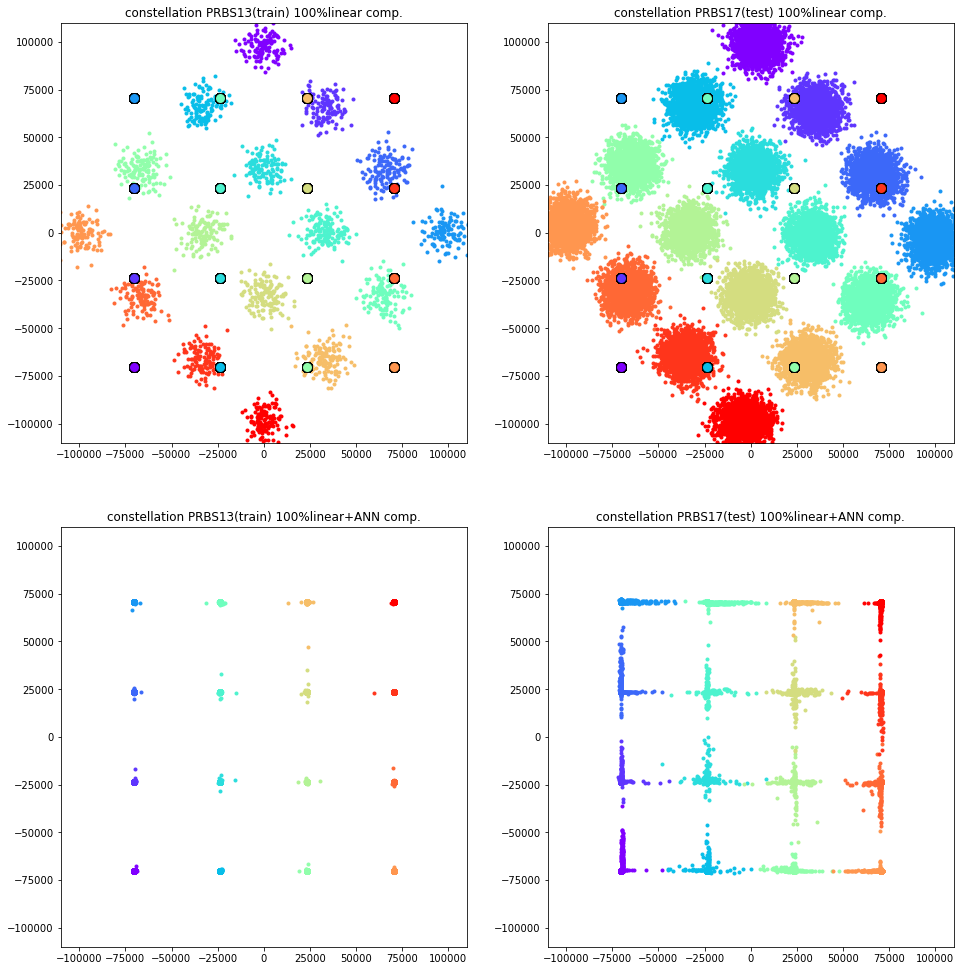

In [35]:
#コンスタレーション可視化
annc0_0 = model_0(train_dataset_0[:][0]).detach().numpy()
annc0_0 = annc0_0 * std_0 + mean_0
annc0_0 = annc0_0[:, 0] + annc0_0[:, 1] * 1j
y0_complex = y0[:, 0] + y0[:, 1] * 1j
annc1_0 = model_0(val_dataset_0[:][0]).detach().numpy()
annc1_0 = annc1_0 * std_0 + mean_0
annc1_0 = annc1_0[:, 0] + annc1_0[:, 1] * 1j
y1_complex = y1[:, 0] + y1[:, 1] * 1j

seq0 = sgnl0.signal['x_0'][16::32]
seq1 = sgnl1.signal['x_0'][16::32]
symbol, inverse, counts = np.unique(seq0, return_inverse=True, return_counts=True)

lim = 110000
cm = plt.get_cmap('rainbow', 16)

fig = plt.figure(figsize=(16, 17))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

for i in range(len(symbol)):
    ax1.plot(lc0[16::32][seq0 == symbol[i]].real, lc0[16::32][seq0 == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=str(counts[i]))
for i in range(len(symbol)):
    ax1.plot(seq0[seq0 == symbol[i]].real, seq0[seq0 == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax1.set_title('constellation PRBS13(train) 100%linear comp.')
ax1.set_xlim(-lim, lim)
ax1.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax2.plot(lc1[16::32][seq1 == symbol[i]].real, lc1[16::32][seq1 == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=str(counts[i]))
for i in range(len(symbol)):
    ax2.plot(seq1[seq1 == symbol[i]].real, seq1[seq1 == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax2.set_title('constellation PRBS17(test) 100%linear comp.')
ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax3.plot(annc0_0[y0_complex == symbol[i]].real, annc0_0[y0_complex == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
for i in range(len(symbol)):
    ax3.plot(y0_complex[y0_complex == symbol[i]].real, y0_complex[y0_complex == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
ax3.set_title('constellation PRBS13(train) 100%linear+ANN comp.')
ax3.set_xlim(-lim, lim)
ax3.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax4.plot(annc1_0[y1_complex == symbol[i]].real, annc1_0[y1_complex == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
for i in range(len(symbol)):
    ax4.plot(y1_complex[y1_complex == symbol[i]].real, y1_complex[y1_complex == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
ax4.set_title('constellation PRBS17(test) 100%linear+ANN comp.')
ax4.set_xlim(-lim, lim)
ax4.set_ylim(-lim, lim);

In [39]:
tap_1 = 1
max_tap = 501
batch_size_1 = 100
hidden_neuron_1 = 100
epochs_1 = 500
lr_1 = 0.001

x0_1 = data_shaping2(annc0_0)
x1_1 = data_shaping2(annc1_0)

mean_1 = np.mean(x0_1)
std_1 = np.std(x0_1)
train_dataset_1 = Dataset(x=x0_1, y=y0, mean=mean_1, std=std_1)
val_dataset_1 = Dataset(x=x1_1, y=y1, mean=mean_1, std=std_1)
train_dataloader_1 = data.DataLoader(train_dataset_1, batch_size=batch_size_1, shuffle=True)
val_dataloader_1 = data.DataLoader(val_dataset_1, batch_size=batch_size_1, shuffle=False)
dataloaders_dict_1 = {'train': train_dataloader_1, 'val': val_dataloader_1}
model_1 = ANN(input_dim=tap_1*2, output_dim=2, hidden_neuron=hidden_neuron_1).to(device)
criterion_1 = nn.MSELoss()
optimizer_1 = optim.Adam(params=model_1.parameters(), lr=lr_1)
model_1 = train_model(device=device, model=model_1, dataloaders_dict=dataloaders_dict_1, criterion=criterion_1, optimizer=optimizer_1, epochs=epochs_1)

0:00:00 | Epoch: 1/500 | train Loss: 0.4415 | EVM: 65.62
0:00:03 | Epoch: 1/500 | val Loss: 0.2402 | EVM: 47.41
0:00:00 | Epoch: 2/500 | train Loss: 0.1416 | EVM: 36.28
0:00:03 | Epoch: 2/500 | val Loss: 0.06135 | EVM: 23.68
0:00:00 | Epoch: 3/500 | train Loss: 0.03263 | EVM: 17.58
0:00:03 | Epoch: 3/500 | val Loss: 0.01303 | EVM: 12.28
0:00:00 | Epoch: 4/500 | train Loss: 0.007274 | EVM: 10.12
0:00:03 | Epoch: 4/500 | val Loss: 0.005185 | EVM: 9.555
0:00:00 | Epoch: 5/500 | train Loss: 0.003467 | EVM: 8.451
0:00:03 | Epoch: 5/500 | val Loss: 0.003584 | EVM: 8.623
0:00:00 | Epoch: 6/500 | train Loss: 0.0022 | EVM: 7.226
0:00:04 | Epoch: 6/500 | val Loss: 0.002647 | EVM: 7.646
0:00:00 | Epoch: 7/500 | train Loss: 0.001603 | EVM: 6.416
0:00:04 | Epoch: 7/500 | val Loss: 0.002285 | EVM: 7.04
0:00:00 | Epoch: 8/500 | train Loss: 0.001343 | EVM: 5.737
0:00:03 | Epoch: 8/500 | val Loss: 0.002089 | EVM: 6.646
0:00:00 | Epoch: 9/500 | train Loss: 0.001161 | EVM: 5.335
0:00:03 | Epoch: 9/500 | 

0:00:03 | Epoch: 70/500 | val Loss: 0.001052 | EVM: 4.413
0:00:00 | Epoch: 71/500 | train Loss: 0.0002033 | EVM: 2.26
0:00:04 | Epoch: 71/500 | val Loss: 0.001053 | EVM: 4.415
0:00:00 | Epoch: 72/500 | train Loss: 0.0002021 | EVM: 2.251
0:00:04 | Epoch: 72/500 | val Loss: 0.001058 | EVM: 4.422
0:00:00 | Epoch: 73/500 | train Loss: 0.0002062 | EVM: 2.265
0:00:04 | Epoch: 73/500 | val Loss: 0.001052 | EVM: 4.415
0:00:00 | Epoch: 74/500 | train Loss: 0.000203 | EVM: 2.253
0:00:04 | Epoch: 74/500 | val Loss: 0.001055 | EVM: 4.418
0:00:00 | Epoch: 75/500 | train Loss: 0.0002039 | EVM: 2.261
0:00:04 | Epoch: 75/500 | val Loss: 0.001051 | EVM: 4.411
0:00:00 | Epoch: 76/500 | train Loss: 0.0002026 | EVM: 2.25
0:00:04 | Epoch: 76/500 | val Loss: 0.001055 | EVM: 4.417
0:00:00 | Epoch: 77/500 | train Loss: 0.0002034 | EVM: 2.255
0:00:04 | Epoch: 77/500 | val Loss: 0.001053 | EVM: 4.415
0:00:00 | Epoch: 78/500 | train Loss: 0.0002027 | EVM: 2.249
0:00:03 | Epoch: 78/500 | val Loss: 0.001047 | EVM:

0:00:00 | Epoch: 139/500 | train Loss: 0.0002014 | EVM: 2.238
0:00:04 | Epoch: 139/500 | val Loss: 0.001053 | EVM: 4.399
0:00:00 | Epoch: 140/500 | train Loss: 0.0002005 | EVM: 2.236
0:00:04 | Epoch: 140/500 | val Loss: 0.001052 | EVM: 4.399
0:00:00 | Epoch: 141/500 | train Loss: 0.0002001 | EVM: 2.228
0:00:04 | Epoch: 141/500 | val Loss: 0.001047 | EVM: 4.396
0:00:00 | Epoch: 142/500 | train Loss: 0.0001983 | EVM: 2.221
0:00:04 | Epoch: 142/500 | val Loss: 0.001057 | EVM: 4.411
0:00:00 | Epoch: 143/500 | train Loss: 0.0001991 | EVM: 2.227
0:00:04 | Epoch: 143/500 | val Loss: 0.001058 | EVM: 4.405
0:00:00 | Epoch: 144/500 | train Loss: 0.0001973 | EVM: 2.219
0:00:04 | Epoch: 144/500 | val Loss: 0.001044 | EVM: 4.394
0:00:00 | Epoch: 145/500 | train Loss: 0.0001984 | EVM: 2.221
0:00:04 | Epoch: 145/500 | val Loss: 0.001047 | EVM: 4.398
0:00:00 | Epoch: 146/500 | train Loss: 0.0002038 | EVM: 2.239
0:00:04 | Epoch: 146/500 | val Loss: 0.001054 | EVM: 4.404
0:00:00 | Epoch: 147/500 | train

0:00:00 | Epoch: 207/500 | train Loss: 0.0001953 | EVM: 2.208
0:00:03 | Epoch: 207/500 | val Loss: 0.001066 | EVM: 4.425
0:00:00 | Epoch: 208/500 | train Loss: 0.0002032 | EVM: 2.234
0:00:03 | Epoch: 208/500 | val Loss: 0.001058 | EVM: 4.402
0:00:00 | Epoch: 209/500 | train Loss: 0.0002023 | EVM: 2.239
0:00:03 | Epoch: 209/500 | val Loss: 0.001048 | EVM: 4.398
0:00:00 | Epoch: 210/500 | train Loss: 0.000197 | EVM: 2.22
0:00:03 | Epoch: 210/500 | val Loss: 0.001044 | EVM: 4.38
0:00:00 | Epoch: 211/500 | train Loss: 0.0001936 | EVM: 2.202
0:00:03 | Epoch: 211/500 | val Loss: 0.001041 | EVM: 4.377
0:00:00 | Epoch: 212/500 | train Loss: 0.0001951 | EVM: 2.206
0:00:03 | Epoch: 212/500 | val Loss: 0.001044 | EVM: 4.384
0:00:00 | Epoch: 213/500 | train Loss: 0.0001991 | EVM: 2.222
0:00:03 | Epoch: 213/500 | val Loss: 0.001037 | EVM: 4.374
0:00:00 | Epoch: 214/500 | train Loss: 0.0001959 | EVM: 2.208
0:00:03 | Epoch: 214/500 | val Loss: 0.001046 | EVM: 4.385
0:00:00 | Epoch: 215/500 | train Lo

0:00:00 | Epoch: 275/500 | train Loss: 0.000195 | EVM: 2.193
0:00:04 | Epoch: 275/500 | val Loss: 0.001073 | EVM: 4.432
0:00:00 | Epoch: 276/500 | train Loss: 0.0001997 | EVM: 2.211
0:00:04 | Epoch: 276/500 | val Loss: 0.001066 | EVM: 4.408
0:00:00 | Epoch: 277/500 | train Loss: 0.0002027 | EVM: 2.233
0:00:04 | Epoch: 277/500 | val Loss: 0.001093 | EVM: 4.46
0:00:00 | Epoch: 278/500 | train Loss: 0.000214 | EVM: 2.242
0:00:04 | Epoch: 278/500 | val Loss: 0.001044 | EVM: 4.373
0:00:00 | Epoch: 279/500 | train Loss: 0.0002017 | EVM: 2.224
0:00:04 | Epoch: 279/500 | val Loss: 0.001031 | EVM: 4.359
0:00:00 | Epoch: 280/500 | train Loss: 0.0001931 | EVM: 2.183
0:00:04 | Epoch: 280/500 | val Loss: 0.001091 | EVM: 4.446
0:00:00 | Epoch: 281/500 | train Loss: 0.0001949 | EVM: 2.191
0:00:04 | Epoch: 281/500 | val Loss: 0.001041 | EVM: 4.373
0:00:00 | Epoch: 282/500 | train Loss: 0.0001886 | EVM: 2.183
0:00:04 | Epoch: 282/500 | val Loss: 0.00102 | EVM: 4.347
0:00:00 | Epoch: 283/500 | train Los

0:00:00 | Epoch: 343/500 | train Loss: 0.0001864 | EVM: 2.154
0:00:03 | Epoch: 343/500 | val Loss: 0.001056 | EVM: 4.389
0:00:00 | Epoch: 344/500 | train Loss: 0.0001894 | EVM: 2.163
0:00:03 | Epoch: 344/500 | val Loss: 0.001018 | EVM: 4.338
0:00:00 | Epoch: 345/500 | train Loss: 0.0001851 | EVM: 2.151
0:00:03 | Epoch: 345/500 | val Loss: 0.00103 | EVM: 4.35
0:00:00 | Epoch: 346/500 | train Loss: 0.0001837 | EVM: 2.148
0:00:03 | Epoch: 346/500 | val Loss: 0.001062 | EVM: 4.401
0:00:00 | Epoch: 347/500 | train Loss: 0.0001947 | EVM: 2.18
0:00:03 | Epoch: 347/500 | val Loss: 0.001048 | EVM: 4.369
0:00:00 | Epoch: 348/500 | train Loss: 0.0001955 | EVM: 2.198
0:00:03 | Epoch: 348/500 | val Loss: 0.001047 | EVM: 4.379
0:00:00 | Epoch: 349/500 | train Loss: 0.0001944 | EVM: 2.189
0:00:03 | Epoch: 349/500 | val Loss: 0.001038 | EVM: 4.367
0:00:00 | Epoch: 350/500 | train Loss: 0.0001861 | EVM: 2.167
0:00:03 | Epoch: 350/500 | val Loss: 0.00103 | EVM: 4.355
0:00:00 | Epoch: 351/500 | train Los

0:00:03 | Epoch: 411/500 | val Loss: 0.001026 | EVM: 4.341
0:00:00 | Epoch: 412/500 | train Loss: 0.0001803 | EVM: 2.137
0:00:03 | Epoch: 412/500 | val Loss: 0.001037 | EVM: 4.364
0:00:00 | Epoch: 413/500 | train Loss: 0.000177 | EVM: 2.135
0:00:03 | Epoch: 413/500 | val Loss: 0.00102 | EVM: 4.341
0:00:00 | Epoch: 414/500 | train Loss: 0.0001836 | EVM: 2.141
0:00:03 | Epoch: 414/500 | val Loss: 0.001016 | EVM: 4.339
0:00:00 | Epoch: 415/500 | train Loss: 0.0001775 | EVM: 2.122
0:00:03 | Epoch: 415/500 | val Loss: 0.001014 | EVM: 4.328
0:00:00 | Epoch: 416/500 | train Loss: 0.0001778 | EVM: 2.124
0:00:03 | Epoch: 416/500 | val Loss: 0.001023 | EVM: 4.346
0:00:00 | Epoch: 417/500 | train Loss: 0.0001891 | EVM: 2.172
0:00:03 | Epoch: 417/500 | val Loss: 0.001024 | EVM: 4.347
0:00:00 | Epoch: 418/500 | train Loss: 0.0001859 | EVM: 2.17
0:00:03 | Epoch: 418/500 | val Loss: 0.001021 | EVM: 4.345
0:00:00 | Epoch: 419/500 | train Loss: 0.0001849 | EVM: 2.139
0:00:03 | Epoch: 419/500 | val Loss

0:00:04 | Epoch: 479/500 | val Loss: 0.001027 | EVM: 4.353
0:00:00 | Epoch: 480/500 | train Loss: 0.0001728 | EVM: 2.128
0:00:03 | Epoch: 480/500 | val Loss: 0.001043 | EVM: 4.376
0:00:00 | Epoch: 481/500 | train Loss: 0.0001703 | EVM: 2.111
0:00:04 | Epoch: 481/500 | val Loss: 0.001026 | EVM: 4.355
0:00:00 | Epoch: 482/500 | train Loss: 0.0001702 | EVM: 2.122
0:00:04 | Epoch: 482/500 | val Loss: 0.001027 | EVM: 4.35
0:00:00 | Epoch: 483/500 | train Loss: 0.000167 | EVM: 2.1
0:00:04 | Epoch: 483/500 | val Loss: 0.001008 | EVM: 4.328
0:00:00 | Epoch: 484/500 | train Loss: 0.0001728 | EVM: 2.121
0:00:04 | Epoch: 484/500 | val Loss: 0.001033 | EVM: 4.362
0:00:00 | Epoch: 485/500 | train Loss: 0.0001811 | EVM: 2.141
0:00:03 | Epoch: 485/500 | val Loss: 0.001054 | EVM: 4.391
0:00:00 | Epoch: 486/500 | train Loss: 0.0001721 | EVM: 2.123
0:00:04 | Epoch: 486/500 | val Loss: 0.00102 | EVM: 4.351
0:00:00 | Epoch: 487/500 | train Loss: 0.0001693 | EVM: 2.115
0:00:04 | Epoch: 487/500 | val Loss: 

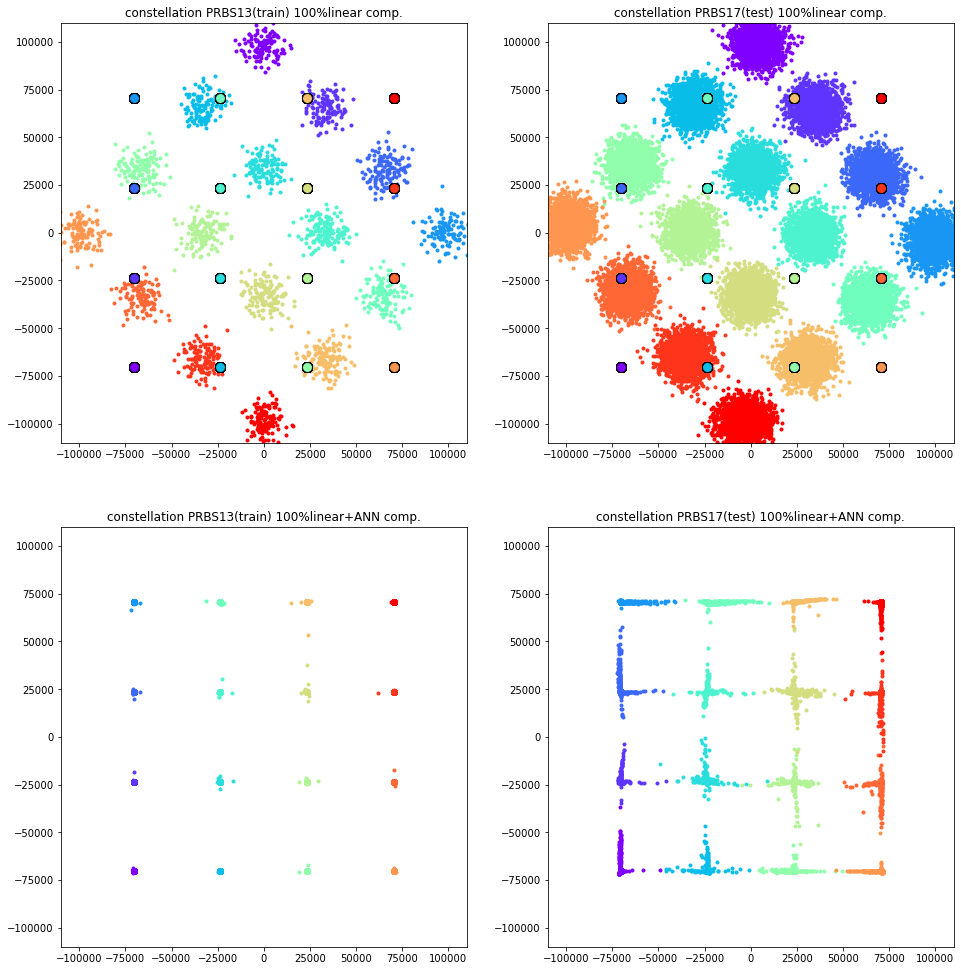

In [40]:
#コンスタレーション可視化
annc0_1 = model_1(train_dataset_1[:][0]).detach().numpy()
annc0_1 = annc0_1 * std_1 + mean_1
annc0_1 = annc0_1[:, 0] + annc0_1[:, 1] * 1j
annc1_1 = model_1(val_dataset_1[:][0]).detach().numpy()
annc1_1 = annc1_1 * std_1 + mean_1
annc1_1 = annc1_1[:, 0] + annc1_1[:, 1] * 1j

lim = 110000
cm = plt.get_cmap('rainbow', 16)

fig = plt.figure(figsize=(16, 17))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

for i in range(len(symbol)):
    ax1.plot(lc0[16::32][seq0 == symbol[i]].real, lc0[16::32][seq0 == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=str(counts[i]))
for i in range(len(symbol)):
    ax1.plot(seq0[seq0 == symbol[i]].real, seq0[seq0 == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax1.set_title('constellation PRBS13(train) 100%linear comp.')
ax1.set_xlim(-lim, lim)
ax1.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax2.plot(lc1[16::32][seq1 == symbol[i]].real, lc1[16::32][seq1 == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=str(counts[i]))
for i in range(len(symbol)):
    ax2.plot(seq1[seq1 == symbol[i]].real, seq1[seq1 == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax2.set_title('constellation PRBS17(test) 100%linear comp.')
ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax3.plot(annc0_1[y0_complex == symbol[i]].real, annc0_1[y0_complex == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
for i in range(len(symbol)):
    ax3.plot(y0_complex[y0_complex == symbol[i]].real, y0_complex[y0_complex == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
ax3.set_title('constellation PRBS13(train) 100%linear+ANN comp.')
ax3.set_xlim(-lim, lim)
ax3.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax4.plot(annc1_1[y1_complex == symbol[i]].real, annc1_1[y1_complex == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
for i in range(len(symbol)):
    ax4.plot(y1_complex[y1_complex == symbol[i]].real, y1_complex[y1_complex == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
ax4.set_title('constellation PRBS17(test) 100%linear+ANN comp.')
ax4.set_xlim(-lim, lim)
ax4.set_ylim(-lim, lim);